In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import re
import math

In [21]:
def parse(root, key):
    dfs = {}
    for f in os.listdir(root):
        df = pd.read_csv(os.path.join(root, f))
        dfs[key(f)] = df
    return dfs

In [4]:
os.makedirs('plots', exist_ok=True)

In [35]:
MARGINS_X = [0.05, 0.05]
MARGINS_Y = [0.05, 0.05]

In [64]:
def plot(dfs):
    mny = math.inf
    mxy = -math.inf
    mnx, mxx = 0, -math.inf

    for factor, df in dfs.items():
        vals = df['Value'].to_numpy()
        plt.plot(vals, label=str(factor))
        mny = min(mny, vals.min())
        mxy = max(mxy, vals.max())
        mxx = max(mxx, len(vals))

    dy = mxy - mny
    dx = mxx - mnx
    plt.xlim(mnx - MARGINS_X[0] * dx, mxx + MARGINS_X[1] * dx)
    plt.ylim(mny - MARGINS_Y[0] * dy, mxy + MARGINS_Y[1] * dy)


In [65]:
def do_complete(root, key, legend_title, ylabel, out_png):
    dfs = parse(root, key=key)
    plot(dfs)

    plt.legend(title=legend_title, fontsize=10)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    assert not os.path.isfile(out_png)
    plt.tight_layout()
    plt.savefig(out_png)

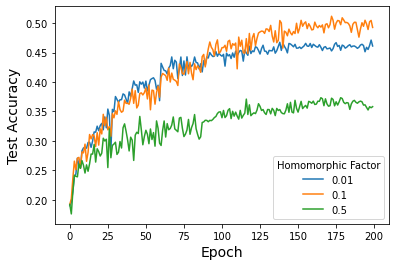

In [53]:
do_complete(
    root='csvs/model/test_acc_subset_lvl=model_ce',
    key=lambda f: re.findall('hf=[^_]+', f)[0].split('=')[1],
    legend_title='Homomorphic Factor',
    ylabel='Test Accuracy',
    out_png='plots/cifar_1000_homo_model_ce_test_acc.png',
)

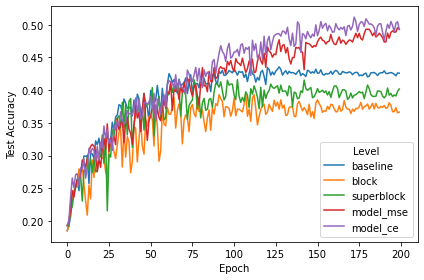

In [69]:
dfs = {
    'baseline': r"C:\Facultate\Tensor-Reloaded\Bias-Variance-Tradeoff-Regularization\csvs\baseline\baseline_test_acc_subset\run-06-18_17-52-33_baseline_subset=1000_runs_PreResNet(56, dataset='CIFAR-10')_Lipschitz-Baseline_Homomorphic-Baseline_mse_0-tag-Test_Accuracy.csv",
    'block': r"C:\Facultate\Tensor-Reloaded\Bias-Variance-Tradeoff-Regularization\csvs\block\test_acc_subset_lvl=block\run-06-18_18-17-59_0_homo=True_hf=100_hlvl=block_subset=1000_runs_PreResNet(56, dataset='CIFAR-10')_Lipschitz-Baseline_Homomorphic-Block-Cons.csv",
    'superblock': r"C:\Facultate\Tensor-Reloaded\Bias-Variance-Tradeoff-Regularization\csvs\superblock\test_acc_subset_lvl=superblock\run-06-18_18-34-51_0_homo=True_hf=5.0_hlvl=superblock_subset=1000_runs_PreResNet(56, dataset='CIFAR-10')_Lipschitz-Baseline_Homomorphic-Supe.csv",
    'model_mse': r"C:\Facultate\Tensor-Reloaded\Bias-Variance-Tradeoff-Regularization\csvs\model\test_acc_subset_lvl=model_mse\run-06-18_19-30-46_0_homo=True_hf=4.0_hlvl=model_subset=1000_runs_PreResNet(56, dataset='CIFAR-10')_Lipschitz-Baseline_Homomorphic-.csv",
    'model_ce': r"C:\Facultate\Tensor-Reloaded\Bias-Variance-Tradeoff-Regularization\csvs\model\test_acc_subset_lvl=model_ce\run-06-18_22-16-04_1_homo=True_hf=0.1_hlvl=model_subset=1000_runs_PreResNet(56, dataset='CIFAR-10')_Lipschitz-Baseline_Homomorphic-M.csv",
}

dfs = {k: pd.read_csv(v) for k, v in dfs.items()}
plot(dfs)
out_png = 'plots/subset_homo_all_test_acc.png'

plt.legend(title='Level')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
assert not os.path.isfile(out_png)
plt.tight_layout()
plt.savefig(out_png)